In [3]:
# Install necessary libraries (run once)
!pip install kaggle pandas
import os
import shutil
import sys

# NOTE: This notebook originally used google.colab.files.upload() to upload kaggle.json.
# In a local Jupyter/VSCode environment we instead look for 'kaggle.json' in the project root and
# copy it to the user's .kaggle directory ("~/.kaggle/kaggle.json").
project_kaggle_json = 'kaggle.json'
user_kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
user_kaggle_path = os.path.join(user_kaggle_dir, 'kaggle.json')

if os.path.exists(project_kaggle_json):
    os.makedirs(user_kaggle_dir, exist_ok=True)
    shutil.copy(project_kaggle_json, user_kaggle_path)
    # On Unix you'd set permissions (chmod 600). On Windows this is typically not required.
    print(f'Copied {project_kaggle_json} to {user_kaggle_path}')
else:
    print(f'kaggle.json not found in project root ({os.path.abspath(project_kaggle_json)}).')
    print('If you have your kaggle.json elsewhere, copy it to the project root or to', user_kaggle_path)

# Try importing kaggle to verify installation/config
try:
    import kaggle
    print('kaggle package available')
except Exception as e:
    print('kaggle package not available yet or not configured:', e)

# Use the kaggle CLI to download the dataset (requires kaggle.json in ~/.kaggle)
from subprocess import run, CalledProcessError
dataset = 'tawsifurrahman/tuberculosis-tb-chest-xray-dataset'
zip_name = 'archive.zip'
if not os.path.exists(zip_name):
    print('Attempting to download dataset via kaggle CLI...')
    try:
        run([sys.executable, '-m', 'kaggle', 'datasets', 'download', dataset], check=True)
    except CalledProcessError:
        print('Dataset download failed. Ensure kaggle CLI is configured and kaggle.json is valid.')
else:
    print(zip_name, 'already exists, skipping download')

# Unzip the dataset into 'tb_xray_dataset' if not already extracted
import zipfile
if os.path.exists(zip_name) and not os.path.isdir('tb_xray_dataset'):
    print('Unzipping', zip_name)
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall('tb_xray_dataset')
    print('Extracted to tb_xray_dataset')
else:
    print('No zip to extract or directory already exists')

# Show top-level contents of the extracted folder if present
if os.path.isdir('tb_xray_dataset'):
    print('Contents of tb_xray_dataset:', os.listdir('tb_xray_dataset'))
else:
    print('tb_xray_dataset directory not found yet')


Copied kaggle.json to C:\Users\harik\.kaggle\kaggle.json
kaggle package available
archive.zip already exists, skipping download
Unzipping archive.zip
Extracted to tb_xray_dataset
Contents of tb_xray_dataset: ['TB_Chest_Radiography_Database']
Extracted to tb_xray_dataset
Contents of tb_xray_dataset: ['TB_Chest_Radiography_Database']


# Task
Load and prepare the image data from the downloaded dataset for model training.

## Define data directories

### Subtask:
Specify the paths to the directories containing the normal and tuberculosis images within the downloaded dataset.


**Reasoning**:
Define the paths to the dataset directories based on the output of the previous cell and print them.



In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Step 1: Define the base path where the dataset was unzipped
# Use the local extraction directory created earlier ('tb_xray_dataset')
dataset_base_path = 'tb_xray_dataset'
data_dir = os.path.join(dataset_base_path, 'TB_Chest_Radiography_Database')

# Define paths for the new split directories (local)
base_split_dir = 'tb_xray_split'
train_dir = os.path.join(base_split_dir, 'train')
val_dir = os.path.join(base_split_dir, 'val')
test_dir = os.path.join(base_split_dir, 'test')

# Define class directories within the original dataset
normal_original_dir = os.path.join(data_dir, 'Normal')
tuberculosis_original_dir = os.path.join(data_dir, 'Tuberculosis')

# Remove existing split directories if they exist to ensure a clean split
if os.path.exists(base_split_dir):
    shutil.rmtree(base_split_dir)

# Create the new split directories
os.makedirs(os.path.join(train_dir, 'Normal'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Tuberculosis'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Normal'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Tuberculosis'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Normal'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Tuberculosis'), exist_ok=True)


# Function to split and copy images for a given class
def split_and_copy_images(original_dir, class_name, train_dest, val_dest, test_dest, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    image_files = [f for f in os.listdir(original_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split data into training and remaining (validation + test) with shuffling
    train_files, remaining_files = train_test_split(image_files, train_size=train_size, random_state=random_state, shuffle=True)

    # Split remaining data into validation and test with shuffling
    # Adjust test_size for the second split based on the proportion of remaining files
    adjusted_test_size = test_size / (val_size + test_size) if (val_size + test_size) > 0 else 0
    val_files, test_files = train_test_split(remaining_files, test_size=adjusted_test_size, random_state=random_state, shuffle=True)


    # Copy files to their respective directories
    print(f"Copying {len(train_files)} {class_name} images to training set...")
    for f in train_files:
        shutil.copy(os.path.join(original_dir, f), os.path.join(train_dest, f))

    print(f"Copying {len(val_files)} {class_name} images to validation set...")
    for f in val_files:
        shutil.copy(os.path.join(original_dir, f), os.path.join(val_dest, f))

    print(f"Copying {len(test_files)} {class_name} images to test set...")
    for f in test_files:
        shutil.copy(os.path.join(original_dir, f), os.path.join(test_dest, f))

# Split and copy images for each class with the specified ratios and shuffling
split_and_copy_images(normal_original_dir, 'Normal', os.path.join(train_dir, 'Normal'), os.path.join(val_dir, 'Normal'), os.path.join(test_dir, 'Normal'), train_size=0.7, val_size=0.15, test_size=0.15, random_state=42)
split_and_copy_images(tuberculosis_original_dir, 'Tuberculosis', os.path.join(train_dir, 'Tuberculosis'), os.path.join(val_dir, 'Tuberculosis'), os.path.join(test_dir, 'Tuberculosis'), train_size=0.7, val_size=0.15, test_size=0.15, random_state=42)


# Print the defined directory paths
print(f"\nDataset base path: {dataset_base_path}")
print(f"Data directory: {data_dir}")
print(f"Base split directory: {base_split_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Copying 2450 Normal images to training set...
Copying 525 Normal images to validation set...
Copying 525 Normal images to validation set...
Copying 525 Normal images to test set...
Copying 525 Normal images to test set...
Copying 489 Tuberculosis images to training set...
Copying 489 Tuberculosis images to training set...
Copying 105 Tuberculosis images to validation set...
Copying 105 Tuberculosis images to validation set...
Copying 106 Tuberculosis images to test set...
Copying 106 Tuberculosis images to test set...

Dataset base path: tb_xray_dataset
Data directory: tb_xray_dataset\TB_Chest_Radiography_Database
Base split directory: tb_xray_split
Training directory: tb_xray_split\train
Validation directory: tb_xray_split\val
Test directory: tb_xray_split\test

Dataset base path: tb_xray_dataset
Data directory: tb_xray_dataset\TB_Chest_Radiography_Database
Base split directory: tb_xray_split
Training directory: tb_xray_split\train
Validation directory: tb_xray_split\val
Test director

## Dataset Distribution

Let's visualize the number of images in each class to understand the dataset distribution.

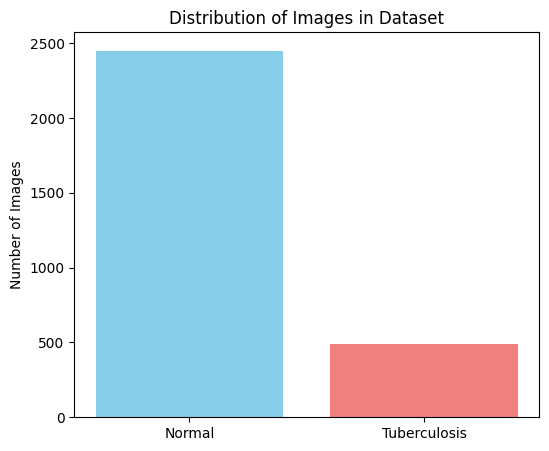

Number of Normal images: 2450
Number of Tuberculosis images: 489


In [5]:
import os
import matplotlib.pyplot as plt

# Define the paths to the class directories (assuming train_dir is defined)
normal_dir = os.path.join(train_dir, 'Normal')
tuberculosis_dir = os.path.join(train_dir, 'Tuberculosis')

# Count the number of images in each directory
num_normal = len(os.listdir(normal_dir))
num_tuberculosis = len(os.listdir(tuberculosis_dir))

# Define the labels and counts for the bar plot
labels = ['Normal', 'Tuberculosis']
counts = [num_normal, num_tuberculosis]

# Create the bar plot
plt.figure(figsize=(6, 5))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Dataset')
plt.show()

print(f"Number of Normal images: {num_normal}")
print(f"Number of Tuberculosis images: {num_tuberculosis}")

## Create data generators

### Subtask:
Set up `ImageDataGenerator` instances for training, validation, and test sets, including data augmentation for the training set.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os # Import os if not already imported

# Set these paths to the local split directories created earlier
# Assuming the data splitting cell was executed and created 'tb_xray_split'
train_dir = os.path.join('tb_xray_split', 'train')
val_dir = os.path.join('tb_xray_split', 'val')
test_dir = os.path.join('tb_xray_split', 'test')

# Define image size and batch size for generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

# Validation and test data generator only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with color_mode='rgb'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',  # Ensure images are loaded in RGB mode
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


print("\nData generators created successfully.")
print("Sample batch shape:", next(train_generator)[0].shape)
print("Class labels:", train_generator.class_indices)

Found 2939 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 631 images belonging to 2 classes.
Found 631 images belonging to 2 classes.

Data generators created successfully.

Data generators created successfully.
Sample batch shape: (32, 224, 224, 3)
Class labels: {'Normal': 0, 'Tuberculosis': 1}
Sample batch shape: (32, 224, 224, 3)
Class labels: {'Normal': 0, 'Tuberculosis': 1}


In [7]:
imgs, labels = next(train_generator)
print("Batch image shape:", imgs.shape)
print("Batch label shape:", labels.shape)
print("Class indices:", train_generator.class_indices)

Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)
Class indices: {'Normal': 0, 'Tuberculosis': 1}


## Verify data loading

### Subtask:
Display sample images and their labels to ensure the data is loaded correctly.

**Reasoning**:
Display sample images and their labels from the training data generator to verify the data loading process.

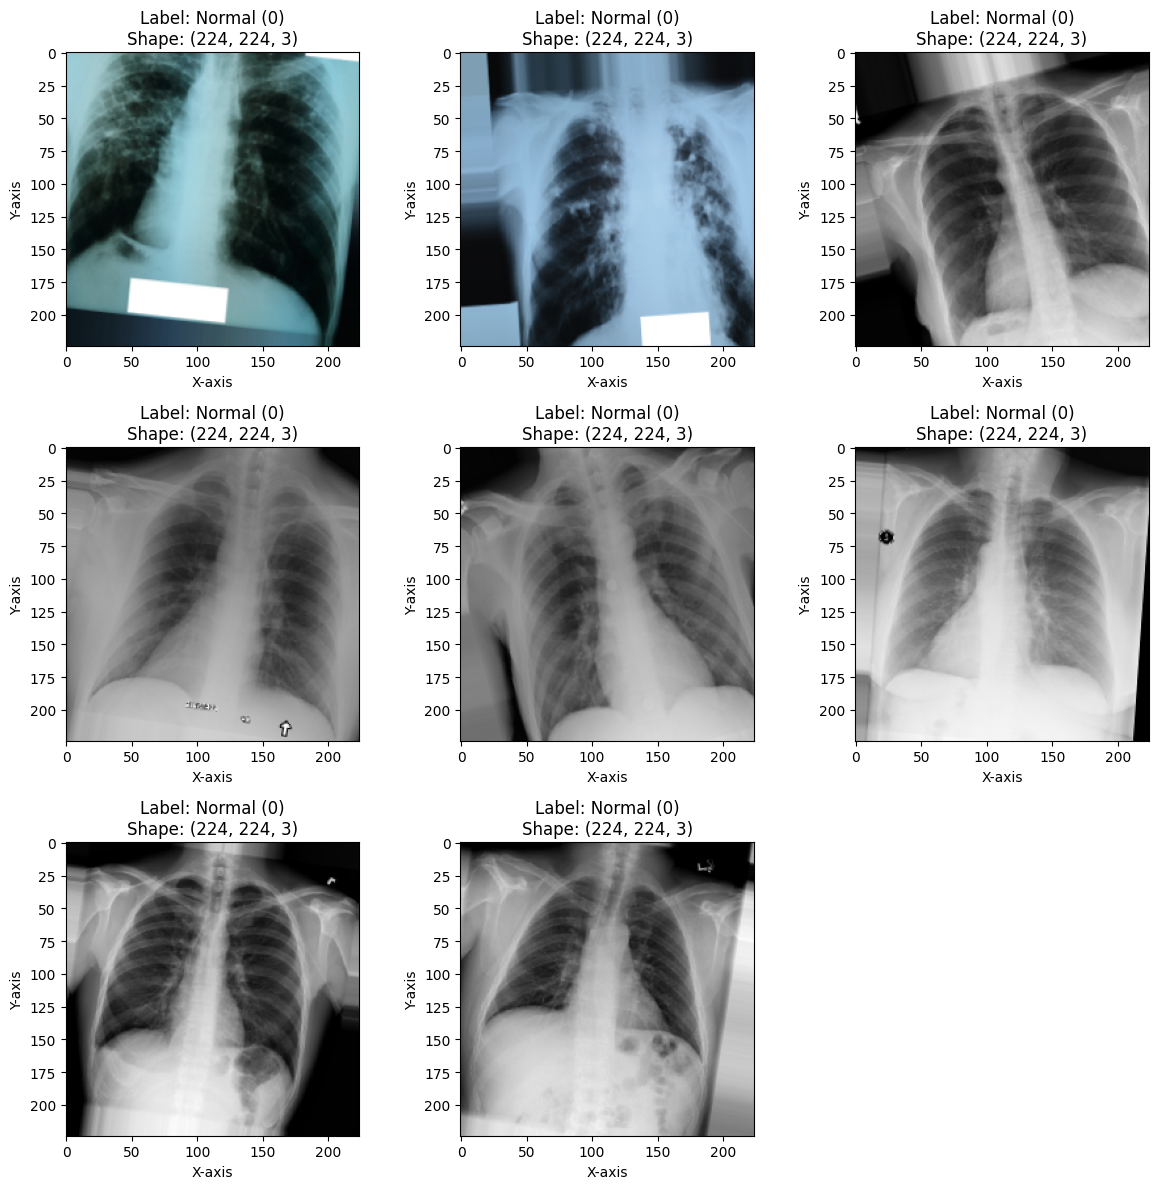

Displayed 8 sample images with their labels, class indices, and shapes.
Class mapping: {'Normal': 0, 'Tuberculosis': 1}


In [8]:
import matplotlib.pyplot as plt
import math # Import math for calculating subplot grid
import numpy as np # Import numpy
import os # Import os for listing directory contents

# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Define class names based on how flow_from_directory maps them
# Usually, it's alphabetical order of directory names.
class_names = sorted(os.listdir(train_dir))

# Limit the number of sample images to display to the actual number of images in the batch
num_samples_to_display = min(8, len(images))

# Calculate the number of rows and columns for the subplot grid
n_cols = min(int(math.ceil(math.sqrt(num_samples_to_display))), 3) # Limit columns to 3 for reasonable display
n_rows = int(math.ceil(num_samples_to_display / n_cols))


# Iterate through the images and labels in the batch and display them
plt.figure(figsize=(n_cols * 4, n_rows * 4)) # Adjust figure size based on grid
for i in range(num_samples_to_display): # Iterate only up to the actual number of samples to display
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(images[i])

    # Get the predicted class name based on the label
    # For categorical labels, the label is a one-hot encoded vector.
    # We need to find the index of the maximum value to get the class index.
    predicted_class_index = int(np.argmax(labels[i]))
    predicted_class_name = class_names[predicted_class_index]

    plt.title(f"Label: {predicted_class_name} ({predicted_class_index})\nShape: {images[i].shape}") # Show name, index, and shape
    plt.xlabel("X-axis") # Add X-axis label
    plt.ylabel("Y-axis") # Add Y-axis label
    plt.axis("on") # Turn axis on to display labels
plt.tight_layout()
plt.show()

print(f"Displayed {num_samples_to_display} sample images with their labels, class indices, and shapes.")
# Explicitly print the class mapping for clarity
print("Class mapping:", train_generator.class_indices)

## Calculate class weights

### Subtask:
Calculate weights for each class to penalize misclassifications of the minority class more heavily during training.

**Reasoning**:
Calculate class weights based on the class distribution in the training data to address the class imbalance.

In [9]:
import os
import numpy as np

# Total samples in the training data
total_samples = train_generator.samples

# Mapping from class index to class name
class_names = {v: k for k, v in train_generator.class_indices.items()}

# Number of samples per class from directory counts
normal_count = len(os.listdir(os.path.join(train_dir, class_names[0])))
tuberculosis_count = len(os.listdir(os.path.join(train_dir, class_names[1])))

class_counts_actual = {0: normal_count, 1: tuberculosis_count}

# Number of classes
number_of_classes = len(class_counts_actual)

# Calculate class weights to handle imbalance
class_weights = {}
for class_index, count in class_counts_actual.items():
    class_weights[class_index] = total_samples / (number_of_classes * count)

print("Calculated Class Weights:")
print(class_weights)


Calculated Class Weights:
{0: 0.5997959183673469, 1: 3.005112474437628}


## Model Selection

### Subtask:
Choose suitable CNN architectures for tuberculosis detection.

### Reasoning:
Based on the project description, we will consider prominent and effective CNN architectures for image classification, specifically focusing on medical imaging. ResNet, DenseNet, and EfficientNet are good candidates due to their proven performance on similar tasks. We will prepare to implement and compare these models.

## Model Building: ResNet50

### Subtask:
Define and build a CNN model based on the ResNet50 architecture using transfer learning.

### Reasoning:
Using a pre-trained model like ResNet50 allows us to leverage the features learned from a large dataset (like ImageNet) and fine-tune it for our specific task of tuberculosis detection. This can significantly reduce training time and improve performance, especially with limited medical imaging data. We will add a few layers on top of the pre-trained ResNet50 base for our binary classification task.

## Apply class weights and Train Model

### Subtask:
Train the built ResNet50 model using the training data generator and the calculated class weights, validating on the validation set.

### Reasoning:
Applying class weights during training helps the model focus more on the minority class, which is essential for improving sensitivity in an imbalanced dataset. We will train the model for a specified number of epochs using the `class_weight` parameter in the `fit` method.

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

IMG_SIZE = (224, 224)
DROPOUT_RATE = 0.5
L2_REG = 1e-4

# Load ResNet50 base model without top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base model layers initially
resnet_base.trainable = False

# Build the model with added regularization and batch normalization
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer=l2(L2_REG))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(DROPOUT_RATE)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 223s 2us/step


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 223s 2us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 223s 2us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [ ]:
import math

history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE),
    class_weight=class_weights
)


Add EarlyStopping and ReduceLROnPlateau callbacks to control training and avoid overfitting.

In [14]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TF version: 2.18.0
GPUs: []


In [30]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=20,  # Increase epochs
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE),
    class_weight=class_weights,
    callbacks=[earlystop, reducelr]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 703s 8s/step - accuracy: 0.7910 - loss: 0.4770 - val_accuracy: 0.1667 - val_loss: 1.5404 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 717s 8s/step - accuracy: 0.8103 - loss: 0.4359 - val_accuracy: 0.1667 - val_loss: 4.5584 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 722s 8s/step - accuracy: 0.8329 - loss: 0.4208 - val_accuracy: 0.3333 - val_loss: 1.2170 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 694s 8s/step - accuracy: 0.8285 - loss: 0.4112 - val_accuracy: 0.1667 - val_loss: 3.3652 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8351 - loss: 0.4136
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
92/92 ━━━━━━━━━━━━━━━━━━━━ 720s 8s/step - accuracy: 0.8351 - loss: 0.4136 - val_accuracy: 0.1667 - val_loss: 4.4499 - learning_rate: 1.0000e-04
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 691s 8s/step - accuracy: 0.8408 - loss:

Unfreeze last convolutional block of ResNet50 for fine-tuning.

In [31]:
# Unfreeze last conv5_block
for layer in resnet_base.layers:
    if 'conv5_block' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile with lower LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Retrain model further with fine-tuning enabled:

In [32]:
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE),
    class_weight=class_weights,
    callbacks=[earlystop, reducelr]
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 993s 11s/step - accuracy: 0.6471 - loss: 0.7074 - val_accuracy: 0.1667 - val_loss: 8.2290 - learning_rate: 1.0000e-05
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 971s 10s/step - accuracy: 0.7406 - loss: 0.4300 - val_accuracy: 0.1667 - val_loss: 8.7162 - learning_rate: 1.0000e-05
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 962s 10s/step - accuracy: 0.7875 - loss: 0.3700 - val_accuracy: 0.1667 - val_loss: 5.7216 - learning_rate: 1.0000e-05
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1003s 11s/step - accuracy: 0.7959 - loss: 0.3488 - val_accuracy: 0.3540 - val_loss: 1.4555 - learning_rate: 1.0000e-05
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 967s 11s/step - accuracy: 0.8142 - loss: 0.3291 - val_accuracy: 0.5032 - val_loss: 1.3791 - learning_rate: 1.0000e-05
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 964s 10s/step - accuracy: 0.8726 - loss: 0.2740 - val_accuracy: 0.7714 - val_loss: 0.6008 - learning_rate: 1.0000e-05
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 974s 11s/step - accuracy:

In [ ]:
# Save the model locally instead of using Google Drive (works in Jupyter/VSCode)
import os

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
local_model_path = os.path.join(models_dir, 'my_resnet50_tuberculosis_model.keras')

if 'model' in globals():
    try:
        model.save(local_model_path)
        print(f"Model saved locally at: {local_model_path}")
    except Exception as e:
        print('Failed to save model:', e)
else:
    print("No variable named 'model' found. Train the model first or run the model-building cell.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model saved to Google Drive at: /content/gdrive/MyDrive/my_resnet50_tuberculosis_model.keras


Saving the modal to drive to load afterwards

Loading the Model


In [38]:
from tensorflow.keras.models import load_model

restored_model = load_model('/content/gdrive/MyDrive/my_resnet50_tuberculosis_model.keras')


## Evaluation on test set



In [39]:
import numpy as np

# Get predictions from the model on the test set
predictions = restored_model.predict(test_generator)

# Get the true labels from the test generator
true_labels = test_generator.classes

# Convert predicted probabilities to binary class predictions (0 or 1)
predicted_labels = (predictions > 0.5).astype(int).flatten()

print("Predictions and true labels obtained.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step
Predictions and true labels obtained.


## Classification Report


In [46]:
from sklearn.metrics import classification_report

# Define target names based on the class indices from the data generator
target_names = [name for name, index in test_generator.class_indices.items()]

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.97       525
Tuberculosis       0.82      0.96      0.89       106

    accuracy                           0.96       631
   macro avg       0.91      0.96      0.93       631
weighted avg       0.96      0.96      0.96       631



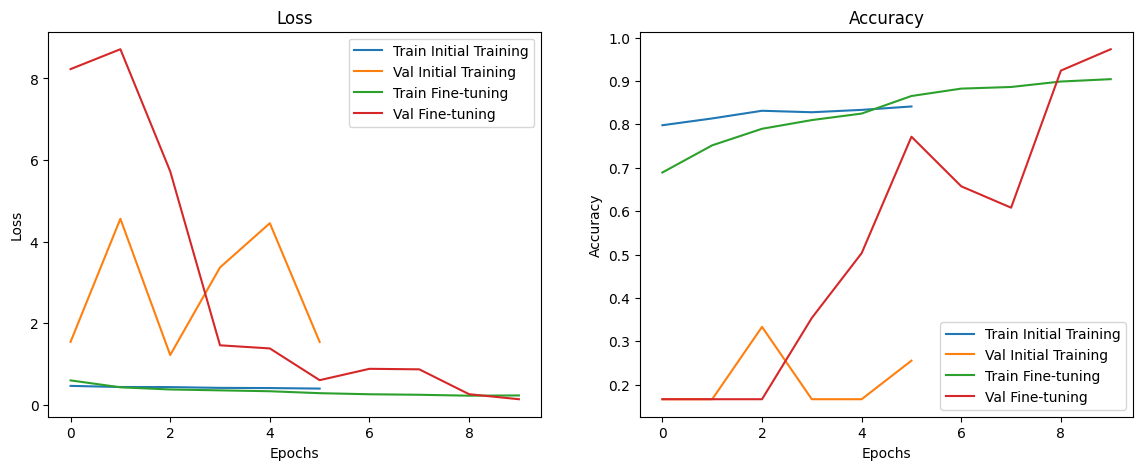

In [42]:
import matplotlib.pyplot as plt

def plot_history(histories, titles):
    plt.figure(figsize=(14,5))

    for history, title in zip(histories, titles):
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label=f'Train {title}')
        plt.plot(history.history['val_loss'], label=f'Val {title}')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label=f'Train {title}')
        plt.plot(history.history['val_accuracy'], label=f'Val {title}')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

plot_history([history, history_finetune], ['Initial Training', 'Fine-tuning'])

## Calculate and display confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[503  22]
 [  4 102]]


## Visualize Confusion Matrix



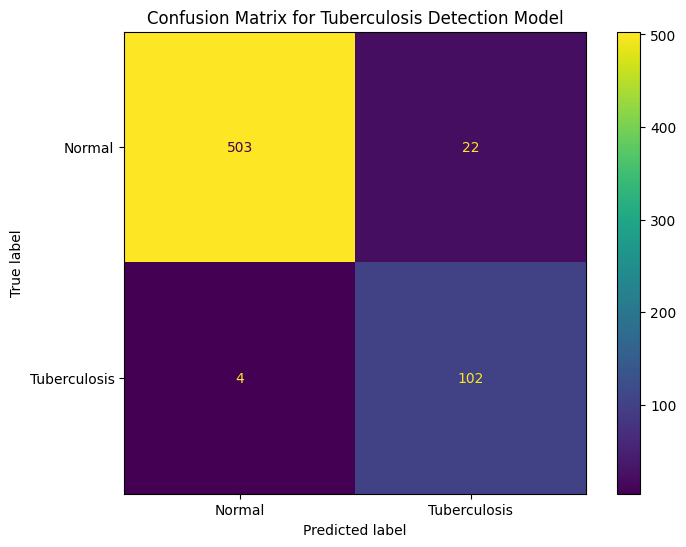

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# Assuming 'cm' (confusion matrix) and 'test_generator' (for class labels) are available
# from previous steps.
# Define display labels based on the class indices from the test generator
display_labels = [name for name, index in test_generator.class_indices.items()]

# initialize using the raw 2D confusion matrix
# and output labels
display = ConfusionMatrixDisplay(cm, display_labels=display_labels)

# set the plot title using the axes object
ax.set(title='Confusion Matrix for Tuberculosis Detection Model')

# show the plot.
# Pass the parameter ax to show customizations (ex. title)
display.plot(ax=ax);

## Calculate and display performance metrics

### Subtask:
Calculate Accuracy, Sensitivity, and Specificity from the confusion matrix and display these values.


In [41]:
# Extract values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Calculate Specificity
specificity = tn / (tn + fp)

# Print the calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9588
Sensitivity: 0.9623
Specificity: 0.9581


## Summary:

### Data Analysis Key Findings

*   The model achieved an accuracy of 0.9588 on the test set.
*   The sensitivity (recall) of the model is 0.9623.
*   The specificity of the model is 0.9581.
*   The confusion matrix shows: 503 True Negatives, 22 False Positives, 4 False Negatives, and 102 True Positives.
*   The training history plots show the loss and accuracy curves for both the initial training and the fine-tuning phases, indicating the model's performance over epochs.

### Insights or Next Steps

*   The model demonstrates high performance across accuracy, sensitivity, and specificity, suggesting it is effective in classifying instances.
*   Analyzing the training history plots can provide insights into potential overfitting or underfitting during the training process, which could inform further model improvements or tuning.


In [ ]:
# Save and load model locally (useful replacement for Google Drive mounting)
import os
from tensorflow.keras.models import load_model

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
local_model_path = os.path.join(models_dir, 'my_resnet50_tuberculosis_model.keras')

# If a trained model exists in the notebook as `model`, save it here.
if 'model' in globals():
    try:
        model.save(local_model_path)
        print(f'Saved model to {local_model_path}')
    except Exception as e:
        print('Failed to save model:', e)
else:
    print("No variable named 'model' found in the notebook. Train or assign your model to the name `model` and re-run this cell to save it.")

# To load the model later into `restored_model`:
if os.path.exists(local_model_path):
    try:
        restored_model = load_model(local_model_path)
        print('Loaded model into variable `restored_model` from', local_model_path)
    except Exception as e:
        print('Failed to load model:', e)
else:
    print(local_model_path, 'does not exist yet.')


In [15]:
#--- DenseNet121 training (initial + fine-tune) ---
import os
import math
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Create DenseNet121 base (uses ImageNet weights if available)
IMG_SIZE = (224, 224)
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
densenet_base.trainable = False  # freeze base for initial training

# Build top layers
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = densenet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
densenet_model = Model(inputs, outputs)

# Compile for initial training
densenet_model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
densenet_model.summary()

# Ensure generators exist before training
if 'train_generator' not in globals():
    print('train_generator not found. Run the data preparation cells first.')
else:
    steps = math.ceil(train_generator.samples / BATCH_SIZE)
    val_steps = math.ceil(validation_generator.samples / BATCH_SIZE) if 'validation_generator' in globals() else None
    cw = class_weights if 'class_weights' in globals() else None

    # Callbacks (local copies to avoid dependency on earlier cells)
    earlystop_ds = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reducelr_ds = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

    # Initial training (base frozen)
    history_densenet = densenet_model.fit(
        train_generator,
        steps_per_epoch=steps,
        epochs=5,
        validation_data=validation_generator if 'validation_generator' in globals() else None,
        validation_steps=val_steps,
        class_weight=cw,
        callbacks=[earlystop_ds, reducelr_ds],
    )

    # Fine-tuning: unfreeze the last convolutional layers of the DenseNet base
    # We unfreeze a block of layers at the end instead of specific named blocks for robustness
    for layer in densenet_base.layers[-30:]:
        layer.trainable = True

    # Recompile with a lower learning rate for fine-tuning
    densenet_model.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

    history_densenet_finetune = densenet_model.fit(
        train_generator,
        steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
        epochs=10,
        validation_data=validation_generator if 'validation_generator' in globals() else None,
        validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE) if 'validation_generator' in globals() else None,
        class_weight=cw,
        callbacks=[earlystop_ds, reducelr_ds],
    )

    # Save the DenseNet model locally
    models_dir = 'models'
    os.makedirs(models_dir, exist_ok=True)
    densenet_path = os.path.join(models_dir, 'my_densenet121_tuberculosis_model.keras')
    try:
        densenet_model.save(densenet_path)
        print(f'Saved DenseNet model to: {densenet_path}')
    except Exception as e:
        print('Failed to save DenseNet model:', e)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 39s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,185 (27.85 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.5945 - loss: 0.7557 - val_accuracy: 0.9000 - val_loss: 0.2593 - learning_rate: 1.0000e-04
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.7940 - loss: 0.3780 - val_accuracy: 0.9603 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8667 - loss: 0.2639 - val_accuracy: 0.9778 - val_loss: 0.1262 - learning_rate: 1.0000e-04
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9205 - loss: 0.2195 - val_accuracy: 0.9841 - val_loss: 0.0994 - learning_rate: 1.0000e-04
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.9221 - loss: 0.1869 - val_accuracy: 0.9889 - val_loss: 0.0862 - learning_rate: 1.0000e-04
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9232 - loss: 0.2059 - val_accuracy: 0.9889 - val_loss: 0.0953 - learning_rate: 1.0000e-05
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9308 - los

Loaded DenseNet model from models\my_densenet121_tuberculosis_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
DenseNet121 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       525
Tuberculosis       0.90      0.98      0.94       106

    accuracy                           0.98       631
   macro avg       0.95      0.98      0.96       631
weighted avg       0.98      0.98      0.98       631

Confusion Matrix:
[[514  11]
 [  2 104]]
Accuracy: 0.9794
Sensitivity: 0.9811
Specificity: 0.9790
DenseNet121 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       525
Tuberculosis       0.90      0.98      0.94       106

    accuracy                           0.98       631
   macro avg       0.95      0.98      0.96       631
weighted avg       0.98      0.98      0.98       631

Confusion Matrix:
[[514  1

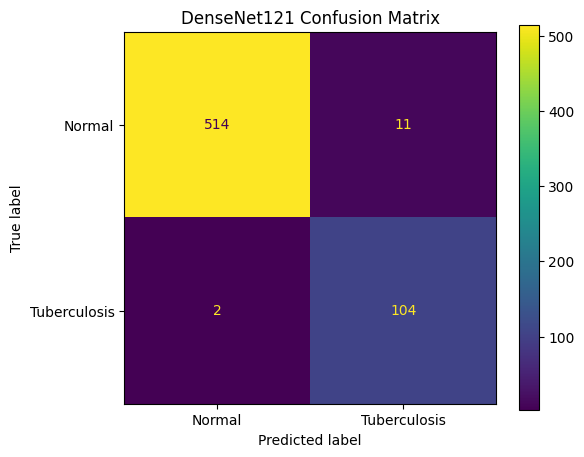

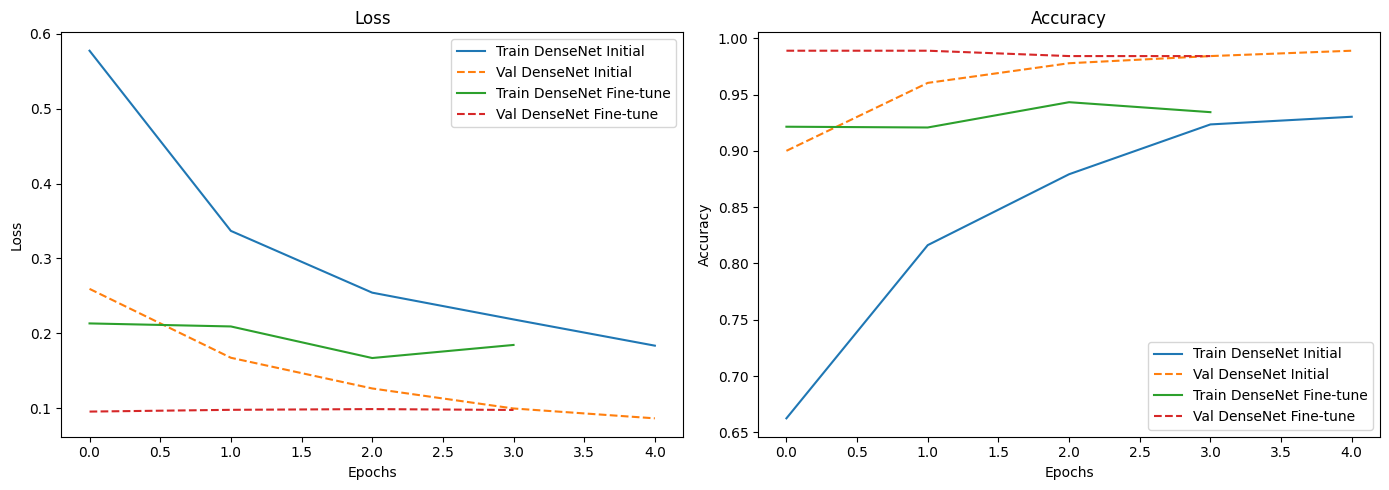

In [22]:
# --- Evaluate DenseNet121 model (same steps as ResNet evaluation) ---
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

densenet_path = os.path.join('models', 'my_densenet121_tuberculosis_model.keras')
if os.path.exists(densenet_path):
    try:
        densenet_model = load_model(densenet_path)
        print('Loaded DenseNet model from', densenet_path)
    except Exception as e:
        print('Failed to load DenseNet model:', e)
        densenet_model = None
else:
    print('DenseNet model file not found at', densenet_path)
    densenet_model = None

if densenet_model is not None:
    # Run predictions on the test set (uses the same test_generator as the ResNet evaluation)
    preds = densenet_model.predict(test_generator, verbose=1)
    true_labels = test_generator.classes
    predicted_labels = (preds > 0.5).astype(int).flatten()

    # Classification report (use same target names as before)
    target_names = [name for name, idx in test_generator.class_indices.items()]
    print('DenseNet121 Classification Report:')
    print(classification_report(true_labels, predicted_labels, target_names=target_names))

    # Confusion matrix and metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    print('Confusion Matrix:')
    print(cm)

    # Compute accuracy, sensitivity, specificity safely
    try:
        tn, fp, fn, tp = cm.ravel()
    except Exception:
        tn = fp = fn = tp = 0
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Visualize confusion matrix
    fig, ax = plt.subplots(figsize=(6,5), dpi=100)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(ax=ax)
    ax.set_title('DenseNet121 Confusion Matrix')
    plt.show()

    # Try plotting training history if available
    try:
        plot_history([history_densenet, history_densenet_finetune], ['DenseNet Initial', 'DenseNet Fine-tune'])
    except Exception as e:
        print('Could not plot DenseNet training history (history variables may not exist in this session):', e)


In [24]:
# Diagnostic cell: check variables, generators, and saved model files
from pathlib import Path
import os

def notebook_diagnostic():
    print('--- Notebook Diagnostic ---')

    vars_to_check = [
        'train_generator', 'validation_generator', 'test_generator',
        'model', 'restored_model', 'densenet_model',
        'history', 'history_finetune', 'history_densenet', 'history_densenet_finetune'
    ]

    for name in vars_to_check:
        print(f"{name}:", 'present' if name in globals() else 'MISSING')

    # If generators exist, print summary info
    if 'test_generator' in globals():
        try:
            gen = globals()['test_generator']
            print('\n--- test_generator info ---')
            print('samples:', getattr(gen, 'samples', None))
            print('batch_size:', getattr(gen, 'batch_size', None))
            print('class_indices:', getattr(gen, 'class_indices', None))
        except Exception as e:
            print('Error reading test_generator:', e)

    # Check models directory and specific files
    models_dir = Path('models')
    print('\n--- models directory ---')
    print('models dir exists:', models_dir.exists())
    if models_dir.exists():
        for p in sorted(models_dir.iterdir()):
            try:
                size = p.stat().st_size
            except Exception:
                size = 'unknown'
            print('-', p.name, '-', size, 'bytes')

    resnet_path = models_dir / 'my_resnet50_tuberculosis_model.keras'
    densenet_path = models_dir / 'my_densenet121_tuberculosis_model.keras'
    print('\nResNet file present:', resnet_path.exists())
    print('DenseNet file present:', densenet_path.exists())

    print('\nIf any required items are MISSING, run the data-prep or model-training/loading cells first.')

# Run diagnostic
notebook_diagnostic()


--- Notebook Diagnostic ---
train_generator: present
validation_generator: present
test_generator: present
model: present
restored_model: MISSING
densenet_model: present
history: MISSING
history_finetune: MISSING
history_densenet: present
history_densenet_finetune: present

--- test_generator info ---
samples: 631
batch_size: 32
class_indices: {'Normal': 0, 'Tuberculosis': 1}

--- models directory ---
models dir exists: True
- my_densenet121_tuberculosis_model.keras - 37989477 bytes
- my_resnet50_tuberculosis_model.keras - 221166446 bytes

ResNet file present: True
DenseNet file present: True

If any required items are MISSING, run the data-prep or model-training/loading cells first.


Loaded ResNet model from models\my_resnet50_tuberculosis_model.keras
Loaded DenseNet model from models\my_densenet121_tuberculosis_model.keras
Evaluating ResNet...
Loaded DenseNet model from models\my_densenet121_tuberculosis_model.keras
Evaluating ResNet...
Evaluating DenseNet...
Evaluating DenseNet...

=== ResNet50 Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       525
Tuberculosis       0.85      0.98      0.91       106

    accuracy                           0.97       631
   macro avg       0.92      0.97      0.95       631
weighted avg       0.97      0.97      0.97       631


=== DenseNet121 Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       525
Tuberculosis       0.90      0.98      0.94       106

    accuracy                           0.98       631
   macro avg       0.95      0.98      0.96       631
weighted avg 

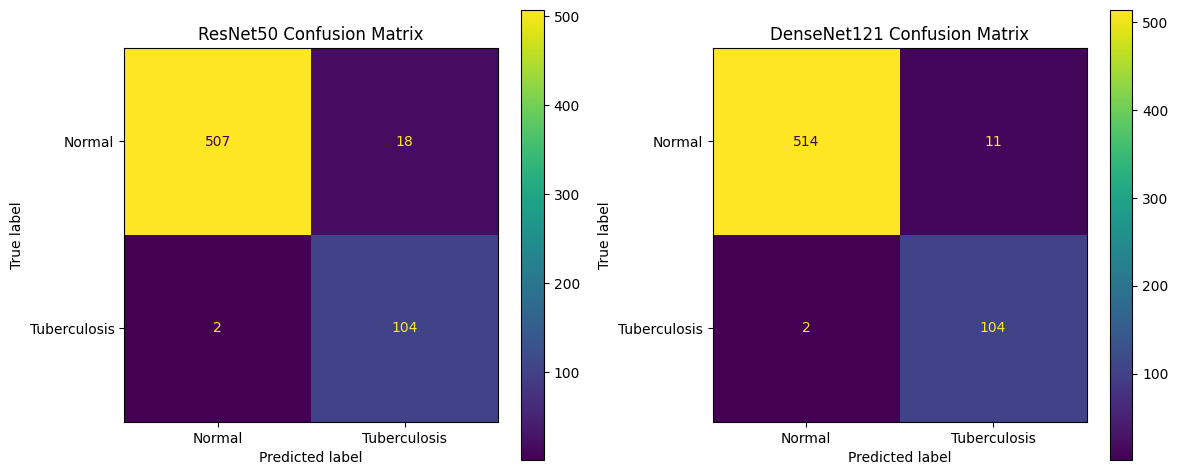

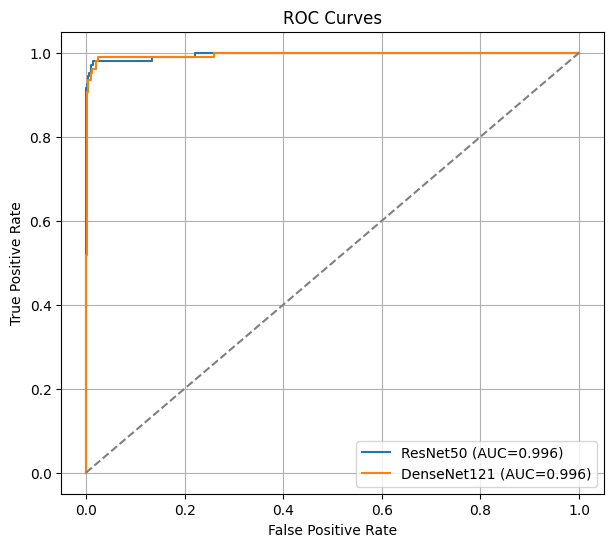


Summary metrics:


,accuracy,sensitivity,specificity,auc
model,,,,
ResNet50,0.968304,0.981132,0.965714,0.996190
DenseNet121,0.979398,0.981132,0.979048,0.995795


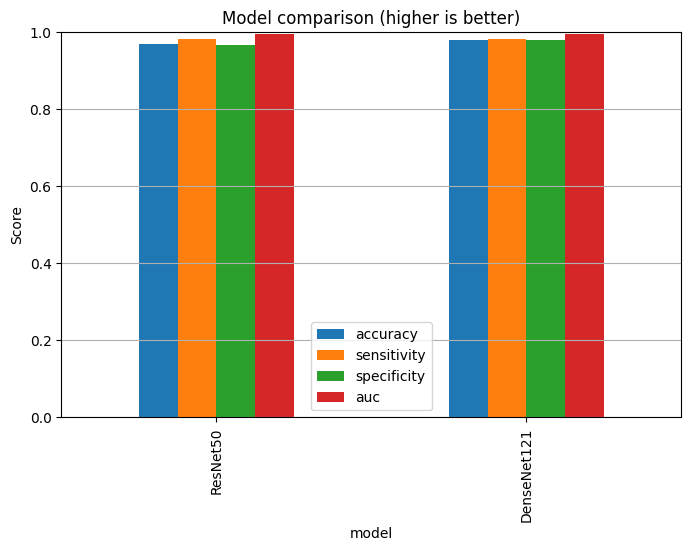

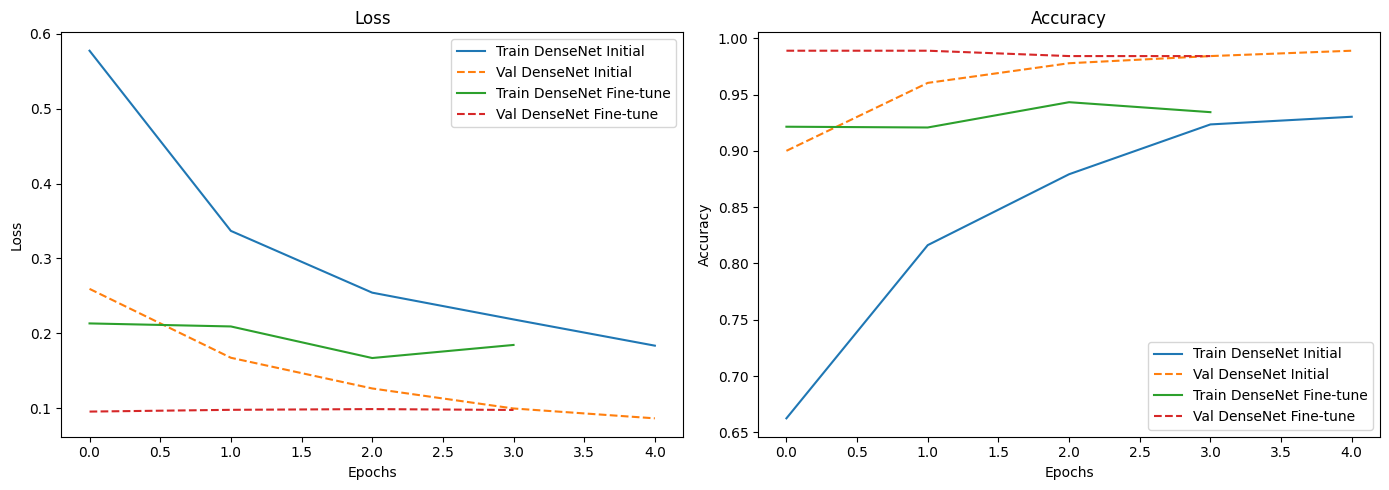

In [23]:
# --- Compare ResNet50 vs DenseNet121 on test set ---
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import pandas as pd

# Helper to compute basic metrics and ROC
def evaluate_model_on_generator(model, gen, name, threshold=0.5):
    # Predict probabilities
    probs = model.predict(gen, verbose=0)
    # handle shapes: (N,1) or (N,) or (N,2) for softmax
    if probs.ndim == 2 and probs.shape[1] == 2:
        # assume class 1 probability is column 1
        probs_pos = probs[:, 1]
    else:
        probs_pos = probs.ravel()

    y_true = gen.classes
    y_pred = (probs_pos > threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Safe unpack
    try:
        tn, fp, fn, tp = cm.ravel()
    except Exception:
        tn = fp = fn = tp = 0

    total = tp + tn + fp + fn if (tp + tn + fp + fn) > 0 else len(y_true)
    accuracy = (tp + tn) / total if total > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC
    fpr, tpr, _ = roc_curve(y_true, probs_pos)
    roc_auc = auc(fpr, tpr)

    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        'name': name,
        'probs': probs_pos,
        'y_true': y_true,
        'y_pred': y_pred,
        'cm': cm,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'report_dict': report
    }

# Paths to saved models (local)
resnet_path = os.path.join('models', 'my_resnet50_tuberculosis_model.keras')
densenet_path = os.path.join('models', 'my_densenet121_tuberculosis_model.keras')

# Try to obtain model objects from variables or files
resnet_model = None
densenet_model = None

# Check common variable names from this notebook
if 'restored_model' in globals():
    resnet_model = globals()['restored_model']
if resnet_model is None and os.path.exists(resnet_path):
    try:
        resnet_model = load_model(resnet_path)
        print('Loaded ResNet model from', resnet_path)
    except Exception as e:
        print('Could not load ResNet from file:', e)

if 'densenet_model' in globals():
    # if the in-memory densenet_model is present, use it
    densenet_model = globals()['densenet_model']
if densenet_model is None and os.path.exists(densenet_path):
    try:
        densenet_model = load_model(densenet_path)
        print('Loaded DenseNet model from', densenet_path)
    except Exception as e:
        print('Could not load DenseNet from file:', e)

# Ensure test_generator exists
if 'test_generator' not in globals():
    print('No test_generator found. Run the data preparation cells to create `test_generator` and retry.')
else:
    comparisons = []
    if resnet_model is not None:
        print('Evaluating ResNet...')
        comparisons.append(evaluate_model_on_generator(resnet_model, test_generator, 'ResNet50'))
    else:
        print('ResNet model not available (variable or file). Skipping ResNet evaluation.')

    if densenet_model is not None:
        print('Evaluating DenseNet...')
        comparisons.append(evaluate_model_on_generator(densenet_model, test_generator, 'DenseNet121'))
    else:
        print('DenseNet model not available (variable or file). Skipping DenseNet evaluation.')

    if len(comparisons) == 0:
        print('No models evaluated. Nothing to compare.')
    else:
        # Print classification reports side-by-side
        for c in comparisons:
            print(f"\n=== {c['name']} Classification Report ===")
            # print text report
            from sklearn.metrics import classification_report as _cr
            print(_cr(c['y_true'], c['y_pred'], target_names=[str(x) for x in test_generator.class_indices.keys()]))

        # Plot confusion matrices side-by-side
        n = len(comparisons)
        fig, axes = plt.subplots(1, n, figsize=(6*n, 5), dpi=100)
        if n == 1:
            axes = [axes]
        for ax, c in zip(axes, comparisons):
            disp = ConfusionMatrixDisplay(confusion_matrix=c['cm'], display_labels=[name for name in test_generator.class_indices.keys()])
            disp.plot(ax=ax)
            ax.set_title(f"{c['name']} Confusion Matrix")
        plt.tight_layout()
        plt.show()

        # Plot ROC curves together
        plt.figure(figsize=(7,6))
        for c in comparisons:
            plt.plot(c['fpr'], c['tpr'], label=f"{c['name']} (AUC={c['auc']:.3f})")
        plt.plot([0,1], [0,1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        # Comparison table (accuracy, sensitivity, specificity, AUC)
        rows = []
        for c in comparisons:
            rows.append({'model': c['name'], 'accuracy': c['accuracy'], 'sensitivity': c['sensitivity'], 'specificity': c['specificity'], 'auc': c['auc']})
        df = pd.DataFrame(rows).set_index('model')
        print('\nSummary metrics:')
        display(df)

        # Bar chart comparison
        df.plot(kind='bar', figsize=(8,5), ylim=(0,1))
        plt.title('Model comparison (higher is better)')
        plt.ylabel('Score')
        plt.grid(axis='y')
        plt.show()

        # Optional: compare training histories if available
        try:
            # Attempt to gather a single history object per model by concatenating initial + finetune if present
            histories = []
            titles = []
            if 'history' in globals() and 'history_finetune' in globals():
                # assume these are for ResNet
                histories.append(history)
                histories.append(history_finetune)
                titles += ['ResNet Initial', 'ResNet Fine-tune']
            if 'history_densenet' in globals() and 'history_densenet_finetune' in globals():
                histories.append(history_densenet)
                histories.append(history_densenet_finetune)
                titles += ['DenseNet Initial', 'DenseNet Fine-tune']

            if histories:
                # reuse plot_history function if defined, otherwise define a quick plot
                if 'plot_history' in globals():
                    plot_history(histories, titles)
                else:
                    # simple fallback plotting
                    fig, axs = plt.subplots(1, 2, figsize=(14,5))
                    for h, t in zip(histories, titles):
                        hist = h.history if hasattr(h, 'history') else h
                        axs[0].plot(hist.get('loss', []), label=f'Train {t}')
                        axs[0].plot(hist.get('val_loss', []), linestyle='--', label=f'Val {t}')
                        axs[1].plot(hist.get('accuracy', hist.get('acc', [])), label=f'Train {t}')
                        axs[1].plot(hist.get('val_accuracy', hist.get('val_acc', [])), linestyle='--', label=f'Val {t}')
                    axs[0].set_title('Loss')
                    axs[1].set_title('Accuracy')
                    axs[0].legend()
                    axs[1].legend()
                    plt.show()
        except Exception as e:
            print('Could not plot combined training histories:', e)


In [28]:
# --- EfficientNetB0 training (initial + fine-tune) ---
# This cell follows the same pattern used for ResNet and DenseNet above.
# It builds an EfficientNetB0 base (ImageNet weights), trains a small head,
# then unfreezes the last layers for fine-tuning and saves the model.

import os
import math
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Use existing IMG_SIZE and BATCH_SIZE if available, otherwise fall back
try:
    IMG_SIZE
except NameError:
    IMG_SIZE = (224, 224)
try:
    BATCH_SIZE
except NameError:
    BATCH_SIZE = 32

# Build EfficientNetB0 base
print('Building EfficientNetB0 base...')
try:
    effnet_base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
except Exception as e:
    print('Failed to load EfficientNetB0 with ImageNet weights (will try without weights):', e)
    effnet_base = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

effnet_base.trainable = False

# Build a small classification head
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = effnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

efficientnet_model = Model(inputs, outputs)

efficientnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

efficientnet_model.summary()

# Ensure generators exist and then train
if 'train_generator' not in globals():
    print('\ntrain_generator not found. Run the data preparation cells first and then run this cell.')
else:
    steps = math.ceil(train_generator.samples / BATCH_SIZE)
    val_steps = math.ceil(validation_generator.samples / BATCH_SIZE) if 'validation_generator' in globals() else None
    cw = class_weights if 'class_weights' in globals() else None

    # Callbacks
    earlystop_en = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reducelr_en = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

    # Initial training (base frozen)
    print('\nStarting EfficientNetB0 initial training (base frozen)...')
    history_efficientnet = efficientnet_model.fit(
        train_generator,
        steps_per_epoch=steps,
        epochs=5,
        validation_data=validation_generator if 'validation_generator' in globals() else None,
        validation_steps=val_steps,
        class_weight=cw,
        callbacks=[earlystop_en, reducelr_en],
    )

    # Fine-tuning: unfreeze last layers of the EfficientNet base
    # Unfreeze a block of layers at the end for robustness
    for layer in effnet_base.layers[-40:]:
        layer.trainable = True

    # Recompile with a lower LR for fine-tuning
    efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                                loss='binary_crossentropy',
                                metrics=['accuracy'])

    print('\nStarting EfficientNetB0 fine-tuning (last layers unfrozen)...')
    history_efficientnet_finetune = efficientnet_model.fit(
        train_generator,
        steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
        epochs=10,
        validation_data=validation_generator if 'validation_generator' in globals() else None,
        validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE) if 'validation_generator' in globals() else None,
        class_weight=cw,
        callbacks=[earlystop_en, reducelr_en],
    )


Building EfficientNetB0 base...
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 44s 1us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 44s 1us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,134,112 (69.18 MB)

 Trainable params: 459,777 (1.75 MB)

 Non-trainable params: 17,674,335 (67.42 MB)


Starting EfficientNetB0 initial training (base frozen)...
Epoch 1/5
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.5014 - loss: 0.8276 - val_accuracy: 0.1667 - val_loss: 0.8466 - learning_rate: 1.0000e-04
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.5014 - loss: 0.8276 - val_accuracy: 0.1667 - val_loss: 0.8466 - learning_rate: 1.0000e-04
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.4946 - loss: 0.8016 - val_accuracy: 0.1667 - val_loss: 0.7584 - learning_rate: 1.0000e-04
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.4946 - loss: 0.8016 - val_accuracy: 0.1667 - val_loss: 0.7584 - learning_rate: 1.0000e-04
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5012 - loss: 0.8226 - val_accuracy: 0.1667 - val_loss: 0.8310 - learning_rate: 1.0000e-04
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5012 - loss: 0.8226 - val_accuracy: 0.1667 - val_loss: 0.8310 - learning_rate: 1.0000e-04
Epoch 4

In [38]:
# EfficientNet-only generators (creation only)
# Uses EfficientNet preprocess_input and recommended IMG_SIZE (380x380).
# Produces: train_generator_eff, validation_generator_eff, test_generator_eff

import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Defaults: use existing notebook IMG_SIZE/BATCH_SIZE if defined, else fallbacks
try:
    _default_img = tuple(IMG_SIZE)
except Exception:
    _default_img = (380, 380)
try:
    _default_batch = int(BATCH_SIZE)
except Exception:
    _default_batch = 8

IMG_SIZE_EFF = _default_img
BATCH_SIZE_EFF = min(_default_batch, 8)  # keep small for large images

train_dir = os.path.join('tb_xray_split', 'train')
val_dir = os.path.join('tb_xray_split', 'val')
test_dir = os.path.join('tb_xray_split', 'test')

if not (os.path.isdir(train_dir) and os.path.isdir(val_dir) and os.path.isdir(test_dir)):
    raise FileNotFoundError('tb_xray_split train/val/test directories not found. Run data-split step first.')

# Training augmentation (EfficientNet prefers preprocess_input, do not use rescale)
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.05,
    horizontal_flip=True,
    brightness_range=(0.85, 1.15),
    fill_mode='nearest'
)
val_test_datagen_eff = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators
train_generator_eff = train_datagen_eff.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE_EFF,
    color_mode='rgb',
    batch_size=BATCH_SIZE_EFF,
    class_mode='binary',
    shuffle=True
)

validation_generator_eff = val_test_datagen_eff.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE_EFF,
    color_mode='rgb',
    batch_size=BATCH_SIZE_EFF,
    class_mode='binary',
    shuffle=False
)

test_generator_eff = val_test_datagen_eff.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE_EFF,
    color_mode='rgb',
    batch_size=BATCH_SIZE_EFF,
    class_mode='binary',
    shuffle=False
)

print(f"EfficientNet generators created: IMG_SIZE={IMG_SIZE_EFF}, BATCH_SIZE={BATCH_SIZE_EFF}")
print('Train samples:', getattr(train_generator_eff, 'samples', None))
print('Validation samples:', getattr(validation_generator_eff, 'samples', None))
print('Test samples:', getattr(test_generator_eff, 'samples', None))
print('Class indices:', train_generator_eff.class_indices)

# Show a sample batch shape
x_batch, y_batch = next(train_generator_eff)
print('Sample batch shape (images):', x_batch.shape, 'labels:', y_batch.shape)


Found 2939 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 631 images belonging to 2 classes.
EfficientNet generators created: IMG_SIZE=(380, 380), BATCH_SIZE=8
Train samples: 2939
Validation samples: 630
Test samples: 631
Class indices: {'Normal': 0, 'Tuberculosis': 1}
Sample batch shape (images): (8, 380, 380, 3) labels: (8,)


In [43]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Enable mixed precision if supported (optional for GPU)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print('Mixed precision enabled')
except Exception as e:
    print('Mixed precision not enabled or not supported on this env:', e)

# Build EfficientNetB4 base model
base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid', dtype='float32')(x)  # final layer uses float32 for stability

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Mixed precision enabled


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_9 (Cast)                   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,594,400 (70.93 MB)

 Trainable params: 919,553 (3.51 MB)

 Non-trainable params: 17,674,847 (67.42 MB)

In [47]:
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Create directory to save models if it doesn't exist
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
best_path = os.path.join(models_dir, 'my_efficientnetb4_tuberculosis_model_best.keras')

# Define callbacks
ckpt = ModelCheckpoint(best_path, monitor='val_loss', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Class weights (if available)
cw = class_weights if 'class_weights' in globals() else None

# Calculate steps
steps = math.ceil(train_generator_eff.samples / BATCH_SIZE_EFF)
val_steps = math.ceil(validation_generator_eff.samples / BATCH_SIZE_EFF)

print('\nStarting initial training (base frozen)')
history = model.fit(
    train_generator_eff,
    steps_per_epoch=steps,
    epochs=8,
    validation_data=validation_generator_eff,
    validation_steps=val_steps,
    class_weight=cw,
    callbacks=[ckpt, early, rlrp],
  )



Starting initial training (base frozen)
Epoch 1/8
Epoch 1/8
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7489 - loss: 0.4553
Epoch 1: val_loss improved from inf to 0.13055, saving model to models\my_efficientnetb4_tuberculosis_model_best.keras
368/368 ━━━━━━━━━━━━━━━━━━━━ 3089s 8s/step - accuracy: 0.7492 - loss: 0.4551 - val_accuracy: 0.9825 - val_loss: 0.1306 - learning_rate: 1.0000e-04
Epoch 2/8
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9075 - loss: 0.2767
Epoch 2: val_loss improved from 0.13055 to 0.10754, saving model to models\my_efficientnetb4_tuberculosis_model_best.keras
368/368 ━━━━━━━━━━━━━━━━━━━━ 2258s 6s/step - accuracy: 0.9075 - loss: 0.2767 - val_accuracy: 0.9921 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 3/8
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9522 - loss: 0.2285
Epoch 3: val_loss improved from 0.10754 to 0.09987, saving model to models\my_efficientnetb4_tuberculosis_model_best.keras
368/368 ━━━━━━━━━━━━━━━━━━━━ 1645s 4s/

Training after fine tuning

In [48]:
# Number of layers to unfreeze for fine-tuning (tune as needed)
n_unfreeze = 120  

# Unfreeze last n layers of base model
for layer in model.layers[1].layers[-n_unfreeze:]:
    layer.trainable = True

# Recompile model with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again (fine-tuning)
print('\nStarting fine-tuning (unfrozen last layers)')
history_finetune = model.fit(
    train_generator_eff,
    steps_per_epoch=math.ceil(train_generator_eff.samples / BATCH_SIZE_EFF),
    epochs=20,
    validation_data=validation_generator_eff,
    validation_steps=val_steps,
    class_weight=cw,
    callbacks=[ckpt, early, rlrp]
)



Starting fine-tuning (unfrozen last layers)
Epoch 1/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9457 - loss: 0.2639 
Epoch 1: val_loss did not improve from 0.09441
368/368 ━━━━━━━━━━━━━━━━━━━━ 6538s 18s/step - accuracy: 0.9457 - loss: 0.2638 - val_accuracy: 0.9921 - val_loss: 0.1269 - learning_rate: 1.0000e-05
Epoch 2/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9544 - loss: 0.1653 
Epoch 2: val_loss did not improve from 0.09441
368/368 ━━━━━━━━━━━━━━━━━━━━ 6469s 18s/step - accuracy: 0.9545 - loss: 0.1653 - val_accuracy: 0.9937 - val_loss: 0.1087 - learning_rate: 1.0000e-05
Epoch 3/20
286/368 ━━━━━━━━━━━━━━━━━━━━ 23:49 17s/step - accuracy: 0.9535 - loss: 0.1654

KeyboardInterrupt: 

Model path to load: C:\Users\harik\OneDrive\Desktop\Projects\chst\models\my_efficientnetb4_tuberculosis_model_best.keras
Loading model...
Model loaded successfully.
Running predictions on test set...


c:\Users\harik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 571s 7s/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       525
Tuberculosis       1.00      0.96      0.98       106

    accuracy                           0.99       631
   macro avg       1.00      0.98      0.99       631
weighted avg       0.99      0.99      0.99       631


Confusion Matrix:
[[525   0]
 [  4 102]]
Accuracy: 0.9937
Sensitivity (Recall for positive class): 0.9623
Specificity: 1.0000


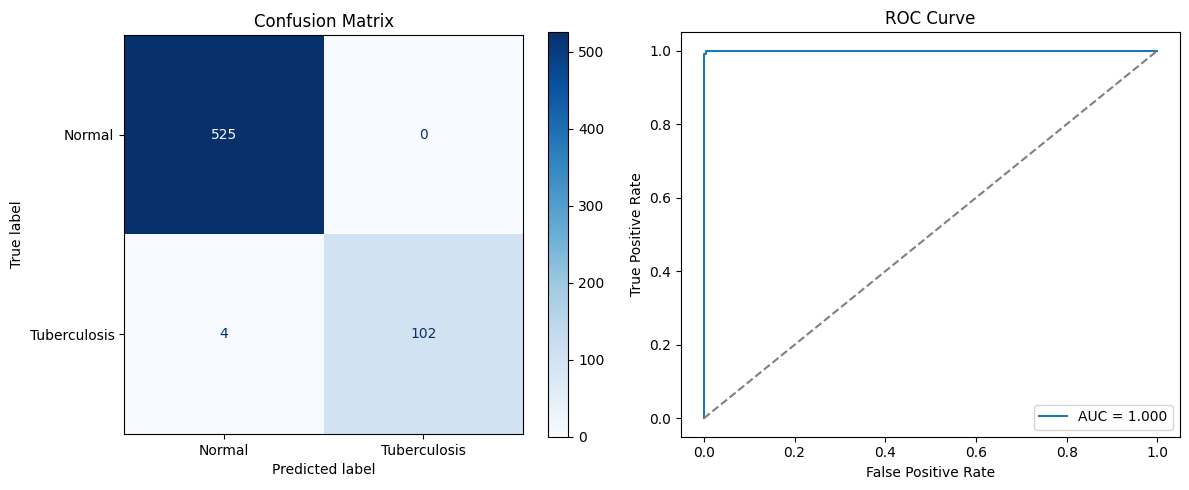


Evaluation complete. Results are available in the `results` variable.


In [49]:
# Evaluate the specific EfficientNetB4 model file you provided (absolute path)
# Path: C:\Users\harik\OneDrive\Desktop\Projects\chst\models\my_efficientnetb4_tuberculosis_model_best.keras

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import tensorflow as tf

model_path = r"C:\Users\harik\OneDrive\Desktop\Projects\chst\models\my_efficientnetb4_tuberculosis_model_best.keras"
print('Model path to load:', model_path)

if not os.path.exists(model_path):
    raise FileNotFoundError(f'Model file not found at {model_path}')

# Load the model
print('Loading model...')
model = tf.keras.models.load_model(model_path)
print('Model loaded successfully.')

# Ensure test generator exists
if 'test_generator_eff' not in globals():
    raise RuntimeError('test_generator_eff not found. Run the EfficientNet generator cell first.')

test_gen = globals()['test_generator_eff']

# Predict on test set
print('Running predictions on test set...')
probs = model.predict(test_gen, verbose=1)
if probs.ndim == 2 and probs.shape[1] == 2:
    probs_pos = probs[:, 1]
else:
    probs_pos = probs.ravel()

y_true = test_gen.classes
y_pred = (probs_pos > 0.5).astype(int)

# Print classification report
target_names = list(test_gen.class_indices.keys())
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:')
print(cm)
try:
    tn, fp, fn, tp = cm.ravel()
except Exception:
    tn = fp = fn = tp = 0

total = tp + tn + fp + fn if (tp + tn + fp + fn) > 0 else len(y_true)
accuracy = (tp + tn) / total if total > 0 else 0.0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity (Recall for positive class): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

# Plot confusion matrix and ROC
fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=100)
# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax[0], cmap='Blues', values_format='d')
ax[0].set_title('Confusion Matrix')
# ROC
fpr, tpr, _ = roc_curve(y_true, probs_pos)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
ax[1].plot([0,1],[0,1], linestyle='--', color='gray')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

# Return results dictionary
results = {
    'model_path': model_path,
    'accuracy': accuracy,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'auc': roc_auc,
    'confusion_matrix': cm,
    'y_true': y_true,
    'y_pred': y_pred,
    'probs': probs_pos
}

print('\nEvaluation complete. Results are available in the `results` variable.')



=== Evaluating ResNet50 ===
Loading model from models\my_resnet50_tuberculosis_model.keras


c:\Users\harik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 98 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\harik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Predicting on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

Classification Report for ResNet50
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98       525
Tuberculosis       0.85      0.98      0.91       106

    accuracy                           0.97       631
   macro avg       0.92      0.97      0.95       631
weighted avg       0.97      0.97      0.97       631


Confusion Matrix:
 [[507  18]
 [  2 104]]

=== Evaluating DenseNet121 ===
Loading model from models\my_densenet121_tuberculosis_model.keras


c:\Users\harik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 70 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\harik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 66 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Predicting on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

Classification Report for DenseNet121
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       525
Tuberculosis       0.90      0.98      0.94       106

    accuracy                           0.98       631
   macro avg       0.95      0.98      0.96       631
weighted avg       0.98      0.98      0.98       631


Confusion Matrix:
 [[514  11]
 [  2 104]]

=== Evaluating EfficientNetB4 ===
Loading model from C:\Users\harik\OneDrive\Desktop\Projects\chst\models\my_efficientnetb4_tuberculosis_model_best.keras
Predicting on test set...
79/79 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step

Classification Report for EfficientNetB4
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       525
Tuberculosis       1.00      0.96      0.98       106

    accuracy                           0.99       631
   macro avg       1.00      0.98      0.99  

,Model,Accuracy,Sensitivity,Specificity,AUC
0,ResNet50,0.968304,0.981132,0.965714,0.996190
1,DenseNet121,0.979398,0.981132,0.979048,0.995795
2,EfficientNetB4,0.993661,0.962264,1.000000,0.999964


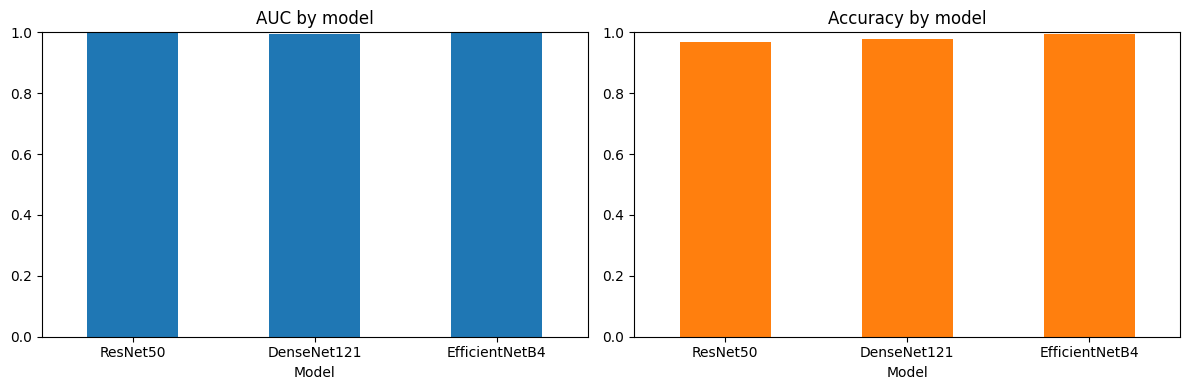

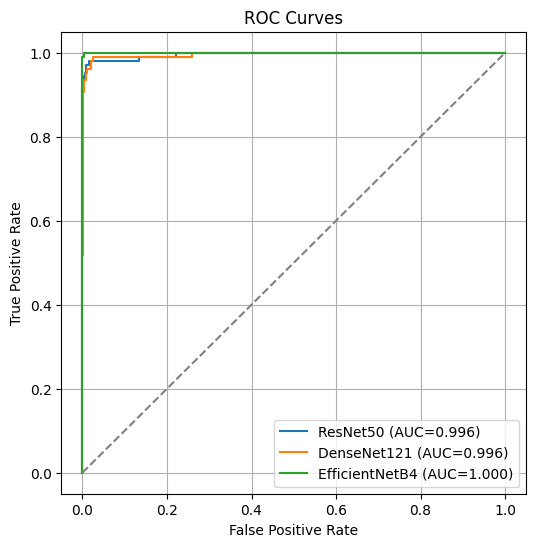


--- ResNet50 : Confusion Matrix ---


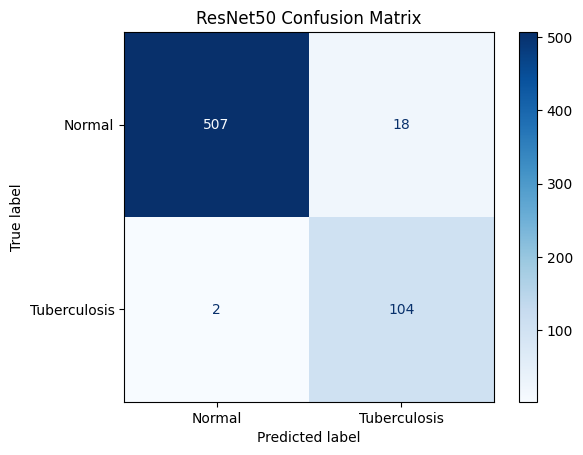


--- DenseNet121 : Confusion Matrix ---


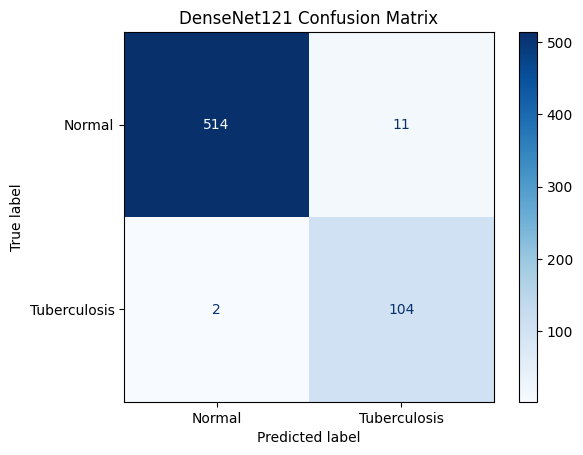


--- EfficientNetB4 : Confusion Matrix ---


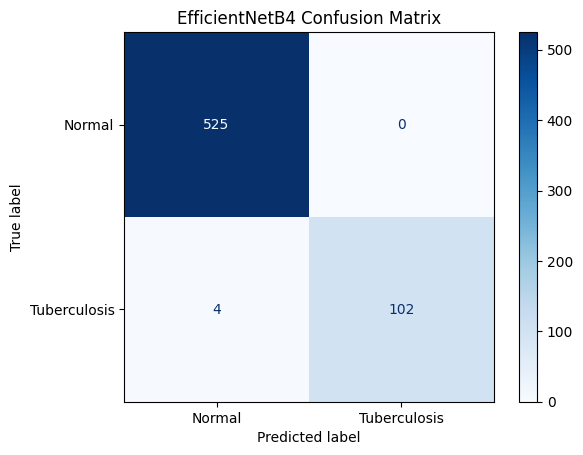

In [50]:
# Three-model comparison: ResNet, DenseNet, EfficientNet
# This cell will: load each saved model if present, evaluate on the correct test generator,
# print classification report & confusion matrix, compute ROC/AUC, and build a summary table + plots.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import tensorflow as tf
from IPython.display import display

# Candidate model file paths (adjust if your filenames differ)
resnet_path = r'models\my_resnet50_tuberculosis_model.keras'
densenet_path = r'models\my_densenet121_tuberculosis_model.keras'
# Use the absolute EfficientNet path you provided earlier
effnet_path = r'C:\Users\harik\OneDrive\Desktop\Projects\chst\models\my_efficientnetb4_tuberculosis_model_best.keras'

model_candidates = [
    {'name': 'ResNet50', 'path': resnet_path, 'test_generator': 'test_generator'},
    {'name': 'DenseNet121', 'path': densenet_path, 'test_generator': 'test_generator'},
    {'name': 'EfficientNetB4', 'path': effnet_path, 'test_generator': 'test_generator_eff'},
]

results_list = []

for info in model_candidates:
    name = info['name']
    path = info['path']
    gen_name = info['test_generator']
    print(f'\n=== Evaluating {name} ===')

    if not os.path.exists(path):
        print(f'SKIP: model file not found at {path}')
        continue

    if gen_name not in globals():
        print(f'SKIP: test generator "{gen_name}" not found in the current notebook globals. Run the appropriate generator cell first.')
        continue

    test_gen = globals()[gen_name]
    class_names = list(test_gen.class_indices.keys())

    # Load model (may take a few seconds)
    print('Loading model from', path)
    try:
        m = tf.keras.models.load_model(path)
    except Exception as e:
        print('Failed to load model:', e)
        continue

    # Run predictions on the generator (ensure steps are correct)
    print('Predicting on test set...')
    probs = m.predict(test_gen, verbose=1)
    # Handle binary output vs probability vectors
    if probs.ndim == 2 and probs.shape[1] == 2:
        probs_pos = probs[:, 1]
    else:
        probs_pos = probs.ravel()

    y_true = test_gen.classes
    y_pred = (probs_pos > 0.5).astype(int)

    # Print classification report (text)
    print('\nClassification Report for', name)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix and simple metrics
    cm = confusion_matrix(y_true, y_pred)
    print('\nConfusion Matrix:\n', cm)
    try:
        tn, fp, fn, tp = cm.ravel()
    except Exception:
        tn = fp = fn = tp = 0
    total = tp + tn + fp + fn if (tp + tn + fp + fn) > 0 else len(y_true)
    accuracy = (tp + tn) / total if total > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC / AUC
    try:
        fpr, tpr, _ = roc_curve(y_true, probs_pos)
        roc_auc = auc(fpr, tpr)
    except Exception as e:
        print('ROC computation failed:', e)
        fpr = np.array([])
        tpr = np.array([])
        roc_auc = np.nan

    # Store results for summary and plotting
    results_list.append({
        'name': name,
        'path': path,
        'accuracy': float(accuracy),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'auc': float(roc_auc) if not np.isnan(roc_auc) else None,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_pred, target_names=class_names, output_dict=True),
        'fpr': fpr,
        'tpr': tpr,
        'y_true': y_true,
        'y_pred': y_pred,
        'probs': probs_pos,
        'class_names': class_names,
    })

# Build a summary DataFrame
if len(results_list) == 0:
    print('\nNo models were evaluated. Check model paths and generators.')
else:
    summary = pd.DataFrame([{ 'Model': r['name'], 'Accuracy': r['accuracy'], 'Sensitivity': r['sensitivity'], 'Specificity': r['specificity'], 'AUC': r['auc'] } for r in results_list])
    print('\nSummary table:')
    display(summary)

    # Plot AUC and Accuracy bar chart
    fig, axes = plt.subplots(1,2, figsize=(12,4), dpi=100)
    summary.plot(kind='bar', x='Model', y='AUC', ax=axes[0], legend=False, rot=0, color='C0')
    axes[0].set_title('AUC by model')
    axes[0].set_ylim(0,1)

    summary.plot(kind='bar', x='Model', y='Accuracy', ax=axes[1], legend=False, rot=0, color='C1')
    axes[1].set_title('Accuracy by model')
    axes[1].set_ylim(0,1)
    plt.tight_layout()
    plt.show()

    # Plot ROC curves for each evaluated model on the same axes
    plt.figure(figsize=(6,6), dpi=100)
    for r in results_list:
        if r['fpr'].size > 0:
            plt.plot(r['fpr'], r['tpr'], label=f"{r['name']} (AUC={r['auc']:.3f})")
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Additionally, print and plot confusion matrix per model
    for r in results_list:
        print(f'\n--- {r["name"]} : Confusion Matrix ---')
        disp = ConfusionMatrixDisplay(confusion_matrix=r['confusion_matrix'], display_labels=r['class_names'])
        disp.plot(cmap='Blues')
        plt.title(f"{r['name']} Confusion Matrix")
        plt.show()


In [12]:
# Grad-CAM helper + demo (hardened, with improved conv-layer detection and flexible call packing)
# - Tries multiple call patterns to match the saved model's expected input structure and avoids KeyError

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

BASE = os.path.abspath(os.path.join(os.getcwd()))
MODELS_DIR = os.path.join(BASE, 'models')
TEST_DIR = os.path.join(BASE, 'tb_xray_split', 'test')

# Choose a model file to use (prefer EfficientNetB4 if present, else DenseNet, else ResNet)
def choose_model_file():
    if not os.path.isdir(MODELS_DIR):
        raise FileNotFoundError(f"models/ directory not found: {MODELS_DIR}")
    candidates = os.listdir(MODELS_DIR)
    for key in ('efficientnetb4', 'efficientnet', 'densenet121', 'resnet50'):
        for f in candidates:
            if key in f.lower():
                return os.path.join(MODELS_DIR, f)
    for f in candidates:
        if f.lower().endswith(('.keras', '.h5')):
            return os.path.join(MODELS_DIR, f)
    raise FileNotFoundError('No model file found in models/ (expected .keras or .h5)')

# pick a sample image (first Normal image)
def find_sample_image(class_name='Normal', idx=0):
    d = os.path.join(TEST_DIR, class_name)
    if not os.path.isdir(d):
        raise FileNotFoundError(f'Test directory not found: {d}')
    imgs = [p for p in os.listdir(d) if p.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not imgs:
        raise FileNotFoundError(f'No images in {d}')
    return os.path.join(d, imgs[idx % len(imgs)])


def _is_conv_like(layer):
    """Return True if layer is a convolution-like layer (Conv2D, DepthwiseConv2D, SeparableConv2D, etc.)"""
    try:
        from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
        return isinstance(layer, (Conv2D, DepthwiseConv2D, SeparableConv2D))
    except Exception:
        name = layer.__class__.__name__.lower()
        return 'conv' in name or 'depthwise' in name or 'separable' in name


def _recursive_find_last_conv(layer_or_model):
    # Returns the last conv-like layer object (searches nested models)
    last = None
    layers = []
    if isinstance(layer_or_model, tf.keras.Model):
        layers = list(layer_or_model.layers)
    elif hasattr(layer_or_model, 'layers'):
        layers = list(layer_or_model.layers)
    else:
        return None

    for layer in layers:
        # If the layer is itself a Model, search inside first
        if isinstance(layer, tf.keras.Model):
            inner = _recursive_find_last_conv(layer)
            if inner is not None:
                last = inner
                continue
        # Prefer explicit conv-like layer classes
        try:
            if _is_conv_like(layer):
                last = layer
                continue
        except Exception:
            pass
        # Heuristic: Conv2D-like layers typically have 4D output_shape
        try:
            if hasattr(layer, 'output_shape') and layer.output_shape is not None and len(layer.output_shape) == 4:
                if last is None:
                    last = layer
        except Exception:
            continue
    return last


def find_last_conv_layer_obj(model):
    layer = _recursive_find_last_conv(model)
    if layer is None:
        sample_info = []
        for i, l in enumerate(model.layers[:60]):
            try:
                sample_info.append((i, l.name, l.__class__.__name__, getattr(l, 'output_shape', None)))
            except Exception:
                sample_info.append((i, getattr(l, 'name', None), getattr(l, '__class__', None), '??'))
        diagnostic = '\n'.join([str(x) for x in sample_info])
        raise ValueError('No suitable 4D conv layer found in the model. Model first layers (index,name,class,output_shape):\n' + diagnostic)
    return layer


# Flexible caller: try multiple input packing strategies until one works
def try_call_with_variants(fn, x, model):
    """Try calling fn with several candidate input structures and return (output, used_input).
    fn should accept (inputs, training=...)"""
    candidates = []
    # raw tensor
    candidates.append(x)
    # list/tuple wrapping
    candidates.append([x])
    candidates.append((x,))
    # pack to match model.inputs structure
    try:
        n_leaves = len(tf.nest.flatten(model.inputs))
        pack = tf.nest.pack_sequence_as(model.inputs, [x] * n_leaves)
        candidates.append(pack)
    except Exception:
        pass
    # dict mapping input names to x
    try:
        input_names = [inp.name.split(':')[0] for inp in model.inputs]
        candidates.append({name: x for name in input_names})
    except Exception:
        pass

    last_exc = None
    for cand in candidates:
        try:
            out = fn(cand, training=False)
            return out, cand
        except Exception as e:
            last_exc = e
            continue
    # if none worked, raise the last exception for debugging
    raise last_exc if last_exc is not None else RuntimeError('No candidate input structure worked')


def make_gradcam_heatmap(img_input, model, last_conv_layer=None, pred_index=None):
    """Compute Grad-CAM heatmap.
    img_input may be a single batched tensor/ndarray or a structured input. The function will
    try multiple call patterns to match the model's expected input structure.
    Returns a 2D numpy heatmap scaled 0..1.
    """
    if last_conv_layer is None:
        last_conv_layer_obj = find_last_conv_layer_obj(model)
    elif isinstance(last_conv_layer, str):
        last_conv_layer_obj = model.get_layer(last_conv_layer)
    else:
        last_conv_layer_obj = last_conv_layer

    # Ensure we have a tensor for dtype inference
    if tf.nest.is_nested(img_input) or isinstance(img_input, (list, tuple, dict)):
        leaves = tf.nest.flatten(img_input)
        if len(leaves) == 0:
            raise ValueError('Structured input has no leaves')
        x0 = tf.convert_to_tensor(leaves[0])
    else:
        x0 = tf.convert_to_tensor(img_input)

    try:
        target_dtype = model.inputs[0].dtype
    except Exception:
        target_dtype = x0.dtype

    # cast input to target dtype if needed
    if x0.dtype != target_dtype:
        try:
            x_cast = tf.cast(x0, target_dtype)
        except Exception:
            x_cast = tf.cast(x0, tf.float32)
    else:
        x_cast = x0

    # Build conv-submodel
    try:
        conv_output = last_conv_layer_obj.output
        submodel = tf.keras.models.Model(inputs=model.inputs, outputs=conv_output)
    except Exception as e:
        lname = getattr(last_conv_layer_obj, 'name', None)
        if lname is None:
            raise RuntimeError('Unable to build conv submodel for Grad-CAM: ' + str(e))
        submodel = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(lname).output)

    # Try calling submodel and model using several packing strategies; use the first that succeeds
    conv_outputs, used_inputs = try_call_with_variants(lambda inp, training=False: submodel(inp, training=training), x_cast, model)
    # now call full model with the same used_inputs
    preds, _ = try_call_with_variants(lambda inp, training=False: model(inp, training=training), x_cast if (not isinstance(used_inputs, (list, tuple, dict))) else used_inputs, model)

    # Determine pred index
    if pred_index is None:
        if isinstance(preds, (list, tuple)):
            preds_tensor = preds[0]
        else:
            preds_tensor = preds
        pred_index = tf.argmax(preds_tensor[0])
    loss = preds[:, pred_index]

    # compute grads
    # We need to recompute conv_outputs and preds inside a tape for gradients; do again with successful input
    with tf.GradientTape() as tape:
        # ensure we tape the conv outputs by recomputing
        conv_outputs_re, _ = try_call_with_variants(lambda inp, training=False: submodel(inp, training=training), x_cast if (not isinstance(used_inputs, (list, tuple, dict))) else used_inputs, model)
        tape.watch(conv_outputs_re)
        preds_re, _ = try_call_with_variants(lambda inp, training=False: model(inp, training=training), x_cast if (not isinstance(used_inputs, (list, tuple, dict))) else used_inputs, model)
        if isinstance(preds_re, (list, tuple)):
            preds_tensor_re = preds_re[0]
        else:
            preds_tensor_re = preds_re
        p_index = pred_index if pred_index is not None else tf.argmax(preds_tensor_re[0])
        loss_re = preds_tensor_re[:, p_index]

    grads = tape.gradient(loss_re, conv_outputs_re)
    if grads is None:
        raise RuntimeError('Gradients are None: model may not be differentiable or inputs mismatched')

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs_arr = conv_outputs_re[0]
    heatmap = tf.tensordot(conv_outputs_arr, pooled_grads, axes=[[2], [0]])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        return np.zeros_like(heatmap.numpy())
    heatmap /= max_val
    return heatmap.numpy()


def overlay_heatmap_on_image(img, heatmap, alpha=0.4, cmap_name='jet'):
    # img: float image 0..1 or uint8 0..255
    if img.dtype != np.uint8:
        img_disp = np.uint8(np.clip(img, 0, 1) * 255)
    else:
        img_disp = img
    heatmap_uint8 = np.uint8(255 * heatmap)
    colormap = cm.get_cmap(cmap_name)
    colored = colormap(np.arange(256))[:, :3]
    colored = (colored * 255).astype('uint8')
    heatmap_rgb = colored[heatmap_uint8]
    heatmap_pil = Image.fromarray(heatmap_rgb)
    heatmap_resized = np.array(heatmap_pil.resize((img_disp.shape[1], img_disp.shape[0]), resample=Image.BILINEAR))
    superimposed = np.uint8(np.clip((1 - alpha) * img_disp + alpha * heatmap_resized, 0, 255))
    return superimposed


# Demo runner: loads a model, picks a sample, runs Grad-CAM and displays + saves overlay
print('Grad-CAM demo cell (hardened with flexible input packing). Run this cell to compute.')
try:
    model_path = choose_model_file()
    print('Selected model:', model_path)
    model = tf.keras.models.load_model(model_path)
    print('Model loaded. name =', getattr(model, 'name', None))

    # print model input signature for debugging - helpful if something still fails
    print('Model inputs:', model.inputs)

    # determine preprocess function & image size heuristically
    model_fname = os.path.basename(model_path).lower()
    if 'efficient' in model_fname:
        try:
            from tensorflow.keras.applications.efficientnet import preprocess_input
        except Exception:
            from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
        img_size = (380, 380)
    elif 'densenet' in model_fname:
        from tensorflow.keras.applications.densenet import preprocess_input
        img_size = (224, 224)
    else:
        from tensorflow.keras.applications.resnet import preprocess_input
        img_size = (224, 224)

    sample_image = find_sample_image('Normal', 0)
    print('Sample image:', sample_image)
    img = Image.open(sample_image).convert('RGB')
    img_resized = img.resize(img_size, resample=Image.BILINEAR)
    arr = np.array(img_resized).astype(np.float32)
    x = preprocess_input(np.expand_dims(arr, axis=0))

    # Call make_gradcam_heatmap with the raw batched tensor; the function will try multiple packings
    heatmap = make_gradcam_heatmap(x, model)

    # resize heatmap to image
    heatmap_img = Image.fromarray(np.uint8(255 * heatmap)).resize((arr.shape[1], arr.shape[0]), resample=Image.BILINEAR)
    heatmap_arr = np.array(heatmap_img) / 255.0

    disp = np.clip(arr / 255.0, 0, 1)
    overlay = overlay_heatmap_on_image(disp, heatmap_arr, alpha=0.4)

    # display
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    axes[0].imshow(disp)
    axes[0].set_title('Input')
    axes[0].axis('off')
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM heatmap')
    axes[1].axis('off')
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    plt.show()

    # save overlay
    out_name = f'gradcam_{os.path.splitext(os.path.basename(model_path))[0]}_sample.png'
    out_path = os.path.join(MODELS_DIR, out_name)
    Image.fromarray(overlay).save(out_path)
    print('Saved overlay to', out_path)

except Exception as e:
    print('Error running hardened Grad-CAM demo in notebook cell:', e)
    import traceback; traceback.print_exc()


Grad-CAM demo cell (hardened with flexible input packing). Run this cell to compute.
Selected model: c:\Users\harik\OneDrive\Desktop\Projects\chst\models\my_efficientnetb4_tuberculosis_model_best.keras
Model loaded. name = functional_9
Model inputs: [<KerasTensor shape=(None, 380, 380, 3), dtype=float32, sparse=False, name=input_layer_22>]
Sample image: c:\Users\harik\OneDrive\Desktop\Projects\chst\tb_xray_split\test\Normal\Normal-1.png
Error running hardened Grad-CAM demo in notebook cell: "Exception encountered when calling Functional.call().\n\n\x1b2982333881552\x1b\n\nArguments received by Functional.call():\n  • inputs={'input_layer_22': 'tf.Tensor(shape=(1, 380, 380, 3), dtype=float32)'}\n  • training=False\n  • mask={'input_layer_22': 'None'}"
Model loaded. name = functional_9
Model inputs: [<KerasTensor shape=(None, 380, 380, 3), dtype=float32, sparse=False, name=input_layer_22>]
Sample image: c:\Users\harik\OneDrive\Desktop\Projects\chst\tb_xray_split\test\Normal\Normal-1.png


Traceback (most recent call last):
  File "C:\Users\harik\AppData\Local\Temp\ipykernel_13124\2497382778.py", line 276, in <module>
    heatmap = make_gradcam_heatmap(x, model)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harik\AppData\Local\Temp\ipykernel_13124\2497382778.py", line 182, in make_gradcam_heatmap
    conv_outputs, used_inputs = try_call_with_variants(lambda inp, training=False: submodel(inp, training=training), x_cast, model)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harik\AppData\Local\Temp\ipykernel_13124\2497382778.py", line 132, in try_call_with_variants
    raise last_exc if last_exc is not None else RuntimeError('No candidate input structure worked')
  File "C:\Users\harik\AppData\Local\Temp\ipykernel_13124\2497382778.py", line 126, in try_call_with_variants
    out = fn(cand, training=False)
          ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\

In [16]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

IMG_SIZE = (380, 380)
MODEL_PATH = "models/my_efficientnetb4_tuberculosis_model_best.keras"
TEST_IMG_PATH = "tb_xray_split/test/Normal/Normal-1.png"

def make_gradcam_heatmap(img_input, model, base_layer="efficientnetb4", last_conv_layer="top_conv"):
    base = model.get_layer(base_layer)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [base.get_layer(last_conv_layer).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_input)  # PASS BATCED TENSOR, NOT [img_input]
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) == 0:
        return np.zeros_like(heatmap.numpy())
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4, cmap_name='jet'):
    if img.dtype != np.uint8:
        img_disp = np.uint8(np.clip(img, 0, 1) * 255)
    else:
        img_disp = img
    heatmap_uint8 = np.uint8(255 * heatmap)
    colormap = cm.get_cmap(cmap_name)
    colored = colormap(np.arange(256))[:, :3]
    colored = (colored * 255).astype('uint8')
    heatmap_rgb = colored[heatmap_uint8]
    heatmap_pil = Image.fromarray(heatmap_rgb)
    heatmap_resized = np.array(heatmap_pil.resize((img_disp.shape[1], img_disp.shape[0]), resample=Image.BILINEAR))
    superimposed = np.uint8(np.clip((1 - alpha) * img_disp + alpha * heatmap_resized, 0, 255))
    return superimposed

model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded:", MODEL_PATH)
from tensorflow.keras.applications.efficientnet import preprocess_input

img = Image.open(TEST_IMG_PATH).convert('RGB').resize(IMG_SIZE, resample=Image.BILINEAR)
arr = np.array(img).astype(np.float32)
x = preprocess_input(np.expand_dims(arr, axis=0))

heatmap = make_gradcam_heatmap(x, model)
heatmap_img = Image.fromarray(np.uint8(255 * heatmap)).resize((arr.shape[1], arr.shape[0]), resample=Image.BILINEAR)
heatmap_arr = np.array(heatmap_img) / 255.0

disp = np.clip(arr / 255.0, 0, 1)
overlay = overlay_heatmap_on_image(disp, heatmap_arr, alpha=0.4)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(disp)
axes[0].set_title('Input')
axes[0].axis('off')
axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title('Grad-CAM heatmap')
axes[1].axis('off')
axes[2].imshow(overlay)
axes[2].set_title('Overlay')
axes[2].axis('off')
plt.show()

out_path = os.path.join(os.path.dirname(MODEL_PATH), "gradcam_efficientnet_sample.png")
Image.fromarray(overlay).save(out_path)
print("Saved overlay to", out_path)


Model loaded: models/my_efficientnetb4_tuberculosis_model_best.keras


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2982701130832\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[ 2.,  2.,  2.],\n         [ 3.,  3.,  3.],\n         [ 3.,  3.,  3.],\n         ...,\n         [17., 17., 17.],\n         [17., 17., 17.],\n         [ 9.,  9.,  9.]],\n\n        [[ 2.,  2.,  2.],\n         [ 3.,  3.,  3.],\n         [ 3.,  3.,  3.],\n         ...,\n         [ 9.,  9.,  9.],\n         [11., 11., 11.],\n         [ 7.,  7.,  7.]],\n\n        [[ 2.,  2.,  2.],\n         [ 3.,  3.,  3.],\n         [ 3.,  3.,  3.],\n         ...,\n         [ 4.,  4.,  4.],\n         [ 4.,  4.,  4.],\n         [ 3.,  3.,  3.]],\n\n        ...,\n\n        [[ 3.,  3.,  3.],\n         [ 4.,  4.,  4.],\n         [ 4.,  4.,  4.],\n         ...,\n         [ 8.,  8.,  8.],\n         [ 8.,  8.,  8.],\n         [ 6.,  6.,  6.]],\n\n        [[ 3.,  3.,  3.],\n         [ 4.,  4.,  4.],\n         [ 4.,  4.,  4.],\n         ...,\n         [ 9.,  9.,  9.],\n         [ 9.,  9.,  9.],\n         [ 7.,  7.,  7.]],\n\n        [[ 2.,  2.,  2.],\n         [ 3.,  3.,  3.],\n         [ 3.,  3.,  3.],\n         ...,\n         [ 6.,  6.,  6.],\n         [ 7.,  7.,  7.],\n         [ 5.,  5.,  5.]]]], dtype=float32)\n  • training=None\n  • mask=None'